In [38]:
import os
import sys
import random
import json
import collections

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [4]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

# Labels

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [7]:
labels_df.shape

(46665, 3)

In [8]:
labels_df['left_site'] = labels_df['left_spec_id'].apply(lambda x: x.split('//')[0])
labels_df['right_site'] = labels_df['right_spec_id'].apply(lambda x: x.split('//')[0])

labels_df['left_file_id'] = labels_df['left_spec_id'].apply(lambda x: x.split('//')[1])
labels_df['right_file_id'] = labels_df['right_spec_id'].apply(lambda x: x.split('//')[1])

In [9]:
labels_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.garricks.com.au//31,www.ebay.com//53278,1,www.garricks.com.au,www.ebay.com,31,53278
1,www.ebay.com//58782,www.ebay.com//24817,0,www.ebay.com,www.ebay.com,58782,24817
2,www.ebay.com//58782,www.ebay.com//43019,0,www.ebay.com,www.ebay.com,58782,43019
3,www.ebay.com//42055,www.ebay.com//54403,0,www.ebay.com,www.ebay.com,42055,54403
4,www.ebay.com//44280,buy.net//6145,0,www.ebay.com,buy.net,44280,6145


In [10]:
labels_df_dup = pd.DataFrame(labels_df[labels_df.label==1])
labels_df_dup.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.garricks.com.au//31,www.ebay.com//53278,1,www.garricks.com.au,www.ebay.com,31,53278
18,www.ebay.com//46524,www.ebay.com//44635,1,www.ebay.com,www.ebay.com,46524,44635
19,www.shopbot.com.au//331,www.mypriceindia.com//155,1,www.shopbot.com.au,www.mypriceindia.com,331,155
60,www.ebay.com//55080,www.ebay.com//47191,1,www.ebay.com,www.ebay.com,55080,47191
73,www.ebay.com//54040,www.ebay.com//54457,1,www.ebay.com,www.ebay.com,54040,54457


In [11]:
labels_df_dup.shape

(3582, 7)

### Classes are very imbalanced

In [12]:
labels_df_dup[(labels_df_dup.right_spec_id=='www.garricks.com.au//31') & (labels_df_dup.left_spec_id=='www.ebay.com//53278')]

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id


### Each duplicate is only included once

In [13]:
labels_df_dup['site_pair'] = labels_df_dup.left_site + ', '+labels_df_dup.right_site

In [14]:
top_pairs = labels_df_dup.site_pair.value_counts().sort_values(ascending=False).head(20)
top_pairs

www.ebay.com, www.ebay.com                1694
www.ebay.com, www.priceme.co.nz            124
www.priceme.co.nz, www.ebay.com            115
www.camerafarm.com.au, www.ebay.com         91
www.shopbot.com.au, www.ebay.com            89
www.ebay.com, www.mypriceindia.com          89
www.ebay.com, www.shopbot.com.au            88
www.ebay.com, www.camerafarm.com.au         77
www.ebay.com, www.walmart.com               65
www.eglobalcentral.co.uk, www.ebay.com      61
www.ebay.com, www.pricedekho.com            58
www.garricks.com.au, www.ebay.com           53
www.shopmania.in, www.ebay.com              52
www.walmart.com, www.ebay.com               51
www.mypriceindia.com, www.ebay.com          51
www.ebay.com, www.shopmania.in              48
www.ebay.com, www.garricks.com.au           45
buy.net, www.ebay.com                       38
www.ebay.com, cammarkt.com                  34
www.ebay.com, buy.net                       34
Name: site_pair, dtype: int64

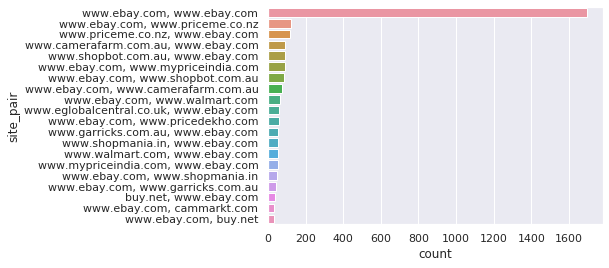

In [15]:
plot_df = labels_df_dup[labels_df_dup.site_pair.isin(top_pairs.index.tolist())]

sns.countplot(y='site_pair', data=plot_df, order=top_pairs.index.tolist())

### It's most important to predict ebay <> ebay duplicates only

# Specs

In [16]:
SPECS_PATH = '../data/raw/2013_camera_specs/'

In [17]:
site_folders = os.listdir(SPECS_PATH)
site_folders

['www.ebay.com',
 'www.price-hunt.com',
 'www.mypriceindia.com',
 'www.pcconnection.com',
 'www.camerafarm.com.au',
 'www.priceme.co.nz',
 'www.pricedekho.com',
 'www.shopbot.com.au',
 'www.walmart.com',
 'www.wexphotographic.com',
 'www.ilgs.net',
 'www.canon-europe.com',
 'www.buzzillions.com',
 'www.ukdigitalcameras.co.uk',
 'www.cambuy.com.au',
 'buy.net',
 'www.garricks.com.au',
 'www.shopmania.in',
 'www.flipkart.com',
 'www.henrys.com',
 'www.alibaba.com',
 'www.gosale.com',
 'cammarkt.com',
 'www.eglobalcentral.co.uk']

In [18]:
site_spec_count = []
for site in site_folders:
    site_spec_count.append((site, len(os.listdir(os.path.join(SPECS_PATH, site)))))
site_spec_count = sorted(site_spec_count, key=lambda x: -x[1])
site_spec_count

[('www.ebay.com', 14274),
 ('www.alibaba.com', 7972),
 ('www.gosale.com', 1002),
 ('www.buzzillions.com', 832),
 ('www.priceme.co.nz', 740),
 ('www.shopmania.in', 630),
 ('www.eglobalcentral.co.uk', 571),
 ('www.shopbot.com.au', 516),
 ('www.pricedekho.com', 366),
 ('buy.net', 358),
 ('www.mypriceindia.com', 347),
 ('www.price-hunt.com', 327),
 ('www.pcconnection.com', 211),
 ('cammarkt.com', 198),
 ('www.walmart.com', 195),
 ('www.henrys.com', 181),
 ('www.canon-europe.com', 164),
 ('www.flipkart.com', 157),
 ('www.wexphotographic.com', 147),
 ('www.garricks.com.au', 130),
 ('www.ukdigitalcameras.co.uk', 129),
 ('www.camerafarm.com.au', 120),
 ('www.cambuy.com.au', 118),
 ('www.ilgs.net', 102)]

### Weird: a lot of specs from alibaba, but alibaba is not even in top by duplicates

#### Pick two random ebay specs

In [19]:
def read_json(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def pprint_json(json_):
    print(json.dumps(json_, indent=4, sort_keys=True))

In [20]:
ebay_specs = os.path.join(SPECS_PATH, 'www.ebay.com')

In [21]:
spec1_path = os.path.join(ebay_specs, random.choice(os.listdir(ebay_specs)))
spec2_path = os.path.join(ebay_specs, random.choice(os.listdir(ebay_specs)))
print(spec1_path)
pprint_json(read_json(spec1_path))
print()
print(spec2_path)
pprint_json(read_json(spec2_path))

../data/raw/2013_camera_specs/www.ebay.com/45939.json
{
    "30inch oled monitor": "Whether composing still images or HD videos, photographers will appreciate the XZ-1's sharp 3.0-inch OLED monitor to frame and show off still images and High Definition (HD) movies in detailed 720p. The LCD displays 610,000 dots in vivid color, reproduces colors and shades more accurately with deeper black tones, and consumes less power. The monitor also provides a wide viewing angle ensuring that images can be composed from even the most obscure angles.",
    "<page title>": "Olympus Stylus XZ 1 10 0 MP Digital Camera Black XZ1 050332175853 | eBay",
    "advanced manual controls": "The XZ-1 offers advanced manual controls that experienced photographers expect from larger digital SLR cameras. But, with the XZ-1, advanced features are easy to use. A control ring around the front of the lens and the wheel controller on the back provide immediate access to the most important manual settings like ISO, apert

### Pick two duplicate specs

In [22]:
ebay_dups_df = labels_df_dup[(labels_df_dup.left_site == 'www.ebay.com') 
                             & (labels_df_dup.right_site == 'www.ebay.com')]
ebay_dups_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id,site_pair
18,www.ebay.com//46524,www.ebay.com//44635,1,www.ebay.com,www.ebay.com,46524,44635,"www.ebay.com, www.ebay.com"
60,www.ebay.com//55080,www.ebay.com//47191,1,www.ebay.com,www.ebay.com,55080,47191,"www.ebay.com, www.ebay.com"
73,www.ebay.com//54040,www.ebay.com//54457,1,www.ebay.com,www.ebay.com,54040,54457,"www.ebay.com, www.ebay.com"
87,www.ebay.com//56845,www.ebay.com//47729,1,www.ebay.com,www.ebay.com,56845,47729,"www.ebay.com, www.ebay.com"
167,www.ebay.com//42173,www.ebay.com//54482,1,www.ebay.com,www.ebay.com,42173,54482,"www.ebay.com, www.ebay.com"


In [23]:
random_row = ebay_dups_df.sample(1)
left_file_id = random_row.left_file_id.values[0]
right_file_id = random_row.right_file_id.values[0]

left_path = os.path.join(ebay_specs, left_file_id+'.json')
right_path = os.path.join(ebay_specs, right_file_id+'.json')

print(left_path)
pprint_json(read_json(left_path))
print()
print(right_path)
pprint_json(read_json(right_path))

../data/raw/2013_camera_specs/www.ebay.com/43077.json
{
    "<page title>": "Sale Brand New Nikon D7000 Body Only 16 2 MP Digital SLR Camera Black Express 018208254682 | eBay",
    "brand": "Nikon",
    "condition": "New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is\napplicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. See the seller's listing for full details.\nSee all condition definitions- opens in a new window or tab\n... Read moreabout the condition",
    "megapixels": "16.2 MP",
    "model": "D7000",
    "mpn": "25468",
    "screen size": "3\"",
    "type": "Digital SLR",
    "upc": "012345984068",
    "warranty": "1 Year Seller Warranty"
}

../data/raw/2013_camera_specs/www.ebay.com/24249.json
{
    "<page title>": "Nikon D7000 16 9 MP Digital SLR Camera w 18 105mm Lens and EXTRAS

Observations:
* brand is included in page title
* can lowercase whole string without any changes
* includes unique product code at the end
* "| eBay" can be cut off
* big intersection of words
* fields on page are mostly included in page title, redudant

## Lets pick two duplicates from different sites

In [24]:
random_row = labels_df_dup.sample(1)
left_site = random_row.left_site.values[0]
left_file_id = random_row.left_file_id.values[0]
right_site = random_row.right_site.values[0]
right_file_id = random_row.right_file_id.values[0]

left_path = os.path.join(SPECS_PATH, left_site, left_file_id+'.json')
right_path = os.path.join(SPECS_PATH, right_site, right_file_id+'.json')

print(left_path)
pprint_json(read_json(left_path))
print()
print(right_path)
pprint_json(read_json(right_path))

../data/raw/2013_camera_specs/www.shopbot.com.au/331.json
{
    "<page title>": "Nikon D90 - Price comparison & reviews - Digital Cameras - Australia",
    "camera type": "SLR",
    "camerastorecomau": "SA",
    "camerastorecomau sa": "Nikon D90 Body Only (1766)\nThe first thing that will amaze photographers about the D90 is its stunning image quality, which takes its inspiration from Nikon's flagship DX-format digital SLR, the D300\n$749.00\nAvailable\nSee offer",
    "digital camera warehouse": "NSW, VIC, QLD",
    "digital camera warehouse nsw vic qld": "Nikon D90 Digital SLR Camera - Body Only\nThis DSLR kit includes the Nikon D90 Body Only. The first thing that will amaze photographers about the D90 is its stunning image quality, which takes its inspiration from Nikon's flagship DX-format digital SLR, the D300. The D90's image sensor and 12.3 effective megapixels combine with Nikon's excl...\nGenuine Australian Warranties Fast Delivery!\n$999.00\n3 more offers\nSee Site\nSee offer

Observations:
* page title has big overlap on brand, model, megapixels
* little-to-no overlap on other fields, most fields are redudant for indentifying a duplicate

Maybe brand can be extracted and simply label-encoded

## Let's see the count of filled fields in ebay

In [25]:
def site_field_counts(site):
    field_counts = collections.Counter()

    for fname in os.listdir(os.path.join(SPECS_PATH, site)):
        path = os.path.join(SPECS_PATH, site, fname)
        parsed = read_json(path)

        for k, v in parsed.items():
            field_counts[k] += 1
    
    field_counts_df = pd.DataFrame(field_counts.items(), columns=['field', 'count']).sort_values(by='count', ascending=False)
    return field_counts_df

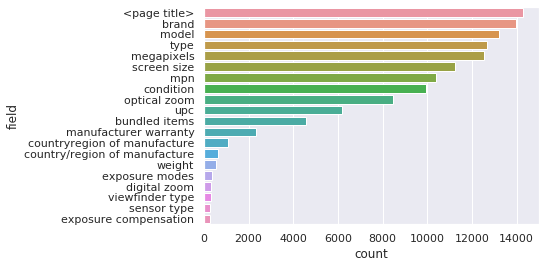

In [26]:
sns.barplot(x='count', y='field', data=site_field_counts('www.ebay.com').head(20))

## Some fields are just errors in spelling, can be easily fixed. We definitely can take only fields that have >=1000 filled values and drop the rest

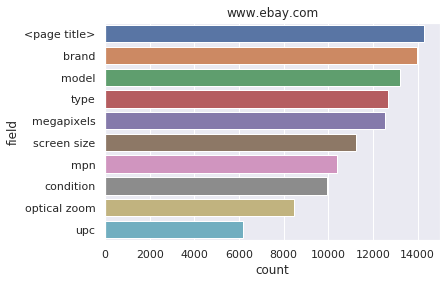

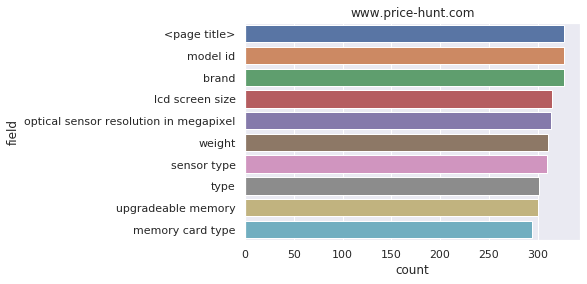

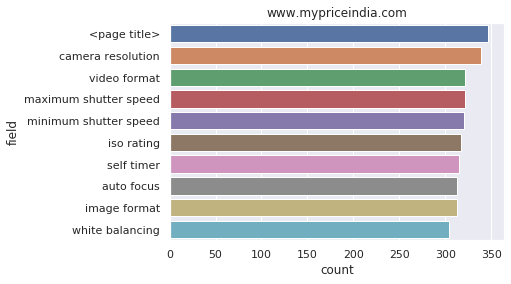

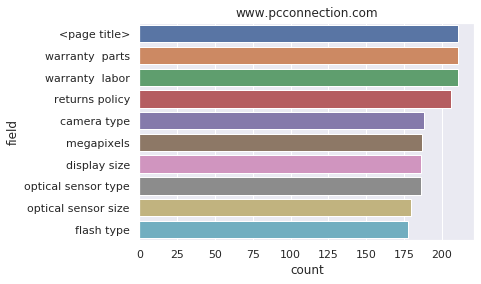

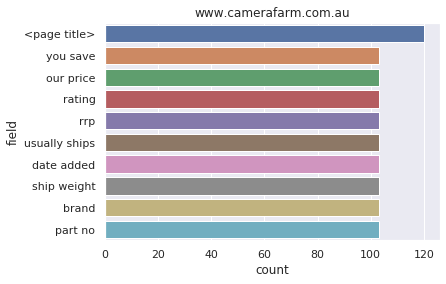

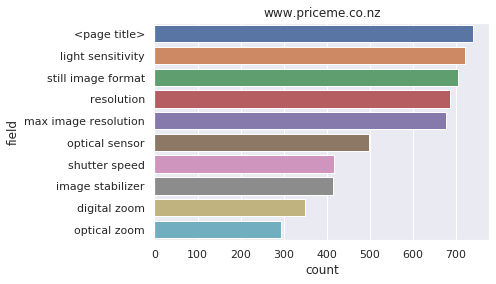

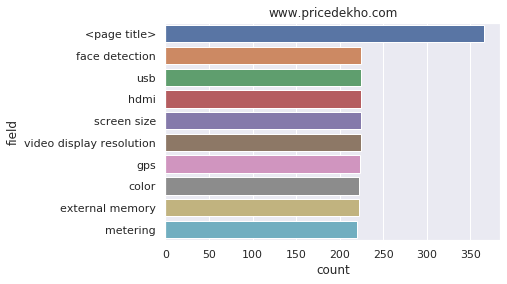

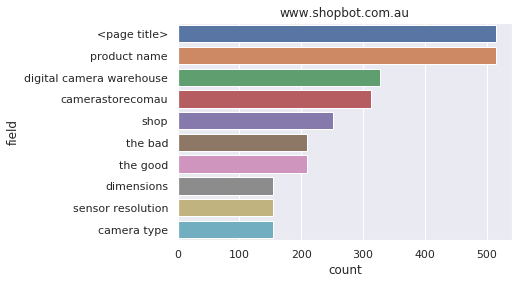

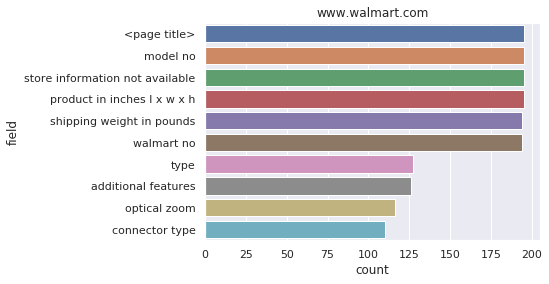

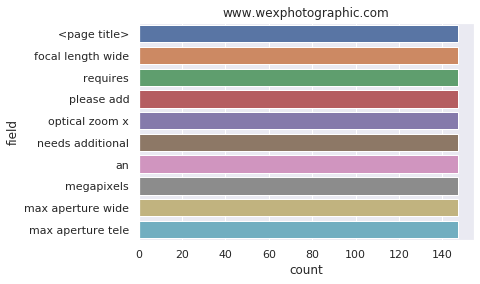

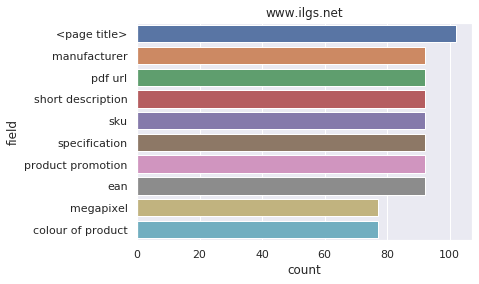

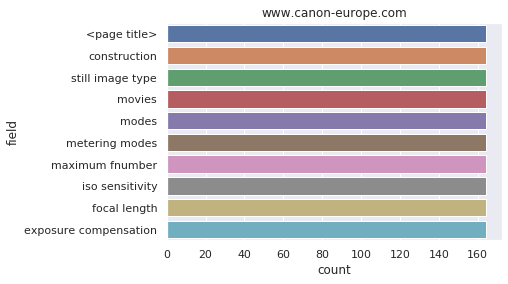

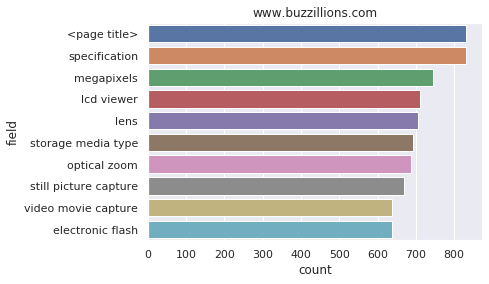

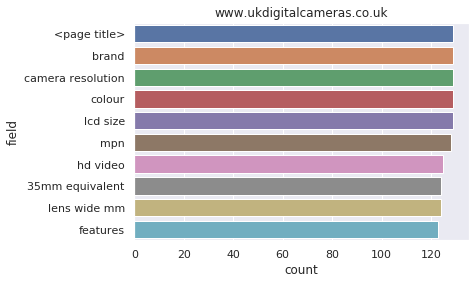

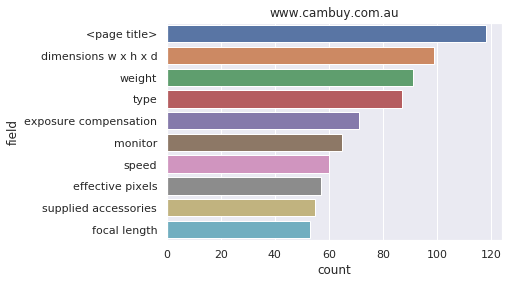

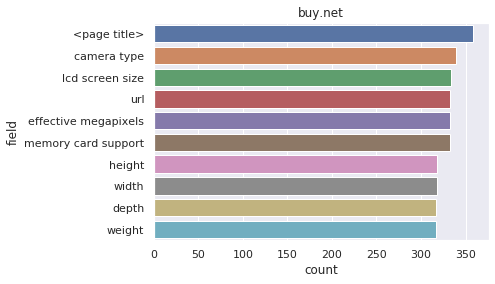

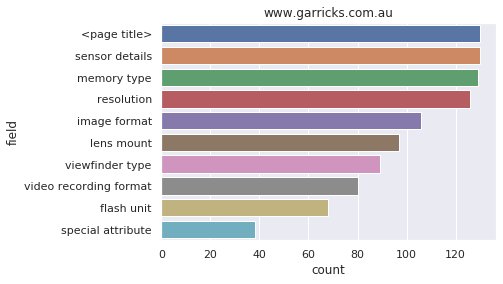

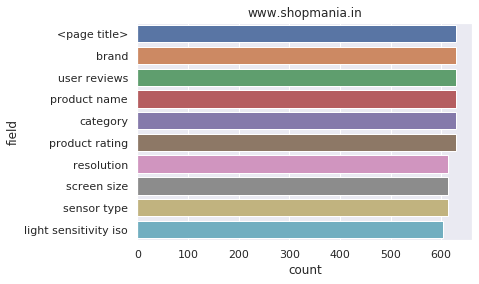

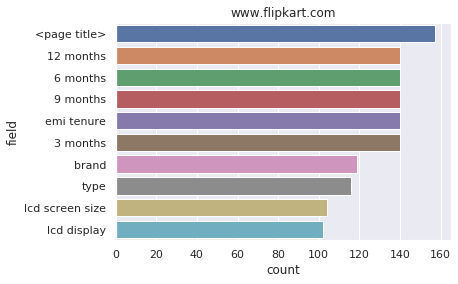

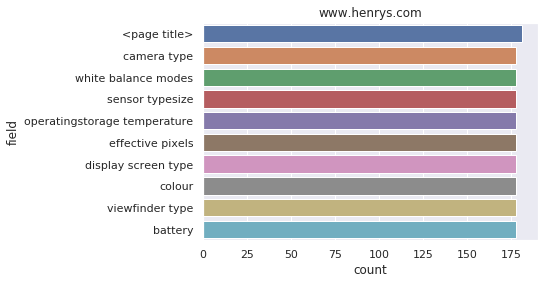

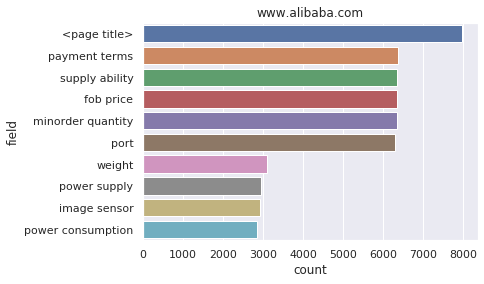

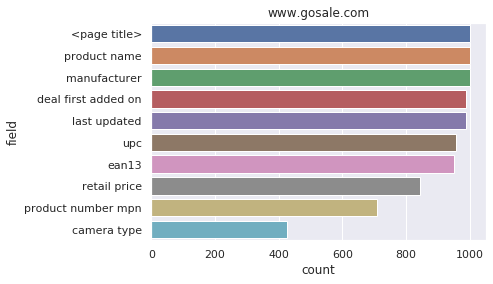

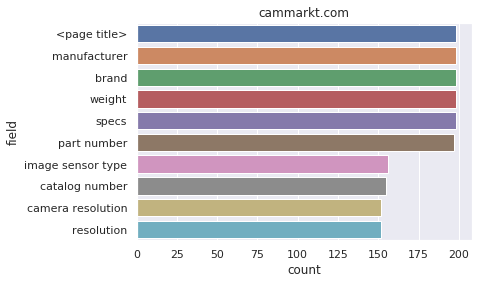

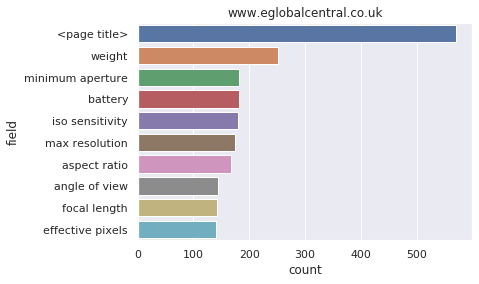

In [27]:
for site in site_folders:
    plt.figure()
    sns.barplot(x='count', y='field', data=site_field_counts(site).head(10))
    plt.title(site)
    plt.show()

## Different sites have really different field sets

# Wordcloud of page titles

## Extract page titles

In [28]:
Row = collections.namedtuple('Row', ['spec_id', 'site', 'page_title'])

In [29]:
rows = []
for site in site_folders:
    for fname in os.listdir(os.path.join(SPECS_PATH, site)):
        path = os.path.join(SPECS_PATH, site, fname)
        parsed = read_json(path)
        row = Row(site+'//'+fname.split('.')[0], site, parsed['<page title>'])
        rows.append(row)
len(rows)

29787

In [30]:
specs_df = pd.DataFrame(rows)
specs_df.head()

,spec_id,site,page_title
0,www.ebay.com//57656,www.ebay.com,Canon PowerShot ELPH 110 HS 16 1 MP Digital Ca...
1,www.ebay.com//60583,www.ebay.com,Canon Rebel 2000 35 mm Camera Great Condition ...
2,www.ebay.com//60440,www.ebay.com,Canon EOS Rebel T3i Digital SLR Camera 18 55mm...
3,www.ebay.com//24139,www.ebay.com,"GE C1033 10 1 MP Digital Camera 3X Zoom 2 4"" L..."
4,www.ebay.com//54903,www.ebay.com,Vivitar Clip Shot Digital Camera 1 1 MP | eBay


In [31]:
huge_string = '\n'.join(specs_df.page_title.values)
huge_string[:400]

'Canon PowerShot ELPH 110 HS 16 1 MP Digital Camera Black | eBay\nCanon Rebel 2000 35 mm Camera Great Condition with Case and Instruction Booklet | eBay\nCanon EOS Rebel T3i Digital SLR Camera 18 55mm Is 75 300mm III Lens Kit USA 609728170592 | eBay\nGE C1033 10 1 MP Digital Camera 3X Zoom 2 4" LCD Black Brand New | eBay\nVivitar Clip Shot Digital Camera 1 1 MP | eBay\nSony Cyber Shot DSC W130 8 1MP Dig'

In [32]:
from wordcloud import WordCloud

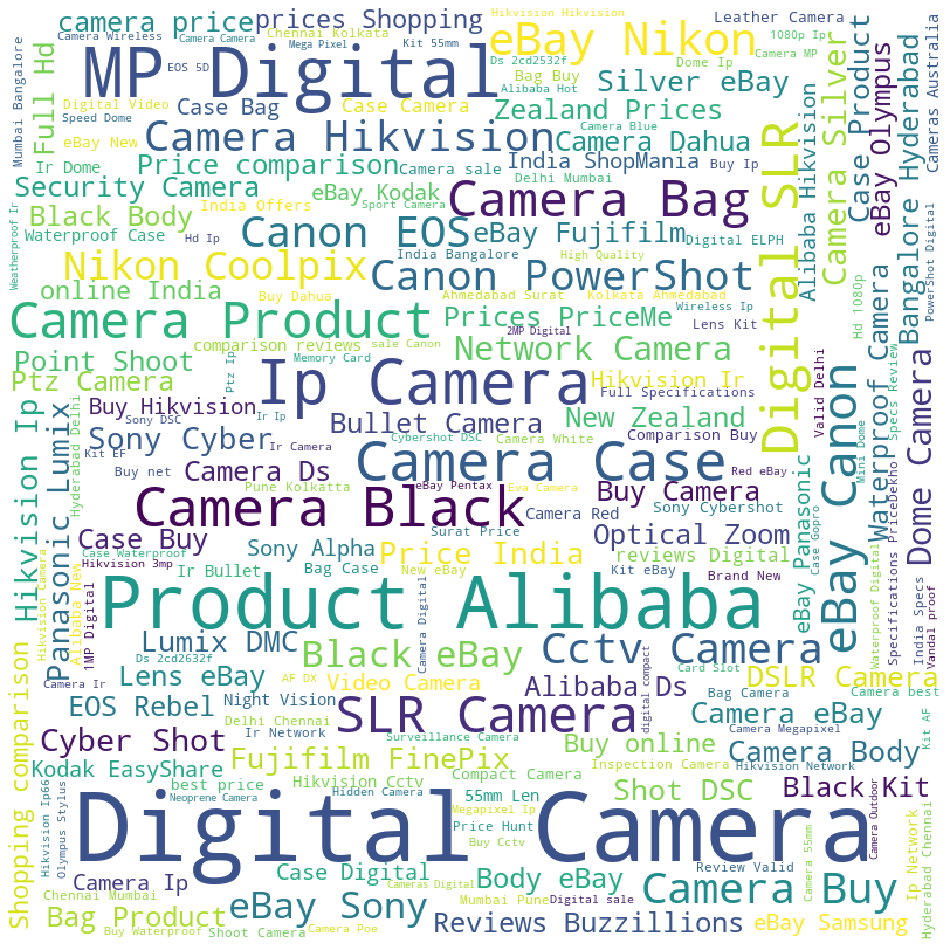

In [33]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(huge_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (13, 13), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Observations:
* SLR, Digital SLR, SLR Camera, Digital Camera, can be replaced with one word combination
* The word "Camera" carries no meaning - all items are cameras in the database
* Except we have camera Bags here? Interesting
* The words "Product", "Price", "Ebay", and other words present only on some sites and on all ads of these sites carry no meaning
* Mumbai? Zealand? India? Delphi? Weird stuff

# Camera brands

In [91]:
major_camera_brands = ['vivitar', 'visiontek', 'vageeswari', 'traveler', 'thomson',
                       'tevion', 'sony', 'sigma', 'samsung', 'rollei', 'ricoh', 'praktica', 
                       'polaroid', 'phase one', 'pentax', 'panasonic', 'olympus', 'nikon',
                       'minox', 'memoto', 'medion', 'lytro', 'leica', 'kodak', 'hp',
                       'hasselblad', 'gopro', 'genius', 'ge', 'fujifilm', 'foscam', 
                       'epson', 'casio', 'canon', 'blackmagic design',
                       'benq', 'bell & howell', 'aigo', 'agfaphoto', 'advert tech',
                       
                       'dahua', 'philips', 'fuji', 'sanyo', 'vizio', 'sharp',
                       'logitech', 'hikvision', 'bell', 'topixo', 'magnavox'
                      ]


In [92]:
def extract_brand(page_title):
    for brand in major_camera_brands:
        if brand in page_title.lower():
            return brand
    return None

specs_df['brand'] = specs_df.page_title.str.replace("Cannon", 'Canon').apply(extract_brand)
specs_df.head()

,spec_id,site,page_title,brand
0,www.ebay.com//57656,www.ebay.com,Canon PowerShot ELPH 110 HS 16 1 MP Digital Ca...,canon
1,www.ebay.com//60583,www.ebay.com,Canon Rebel 2000 35 mm Camera Great Condition ...,canon
2,www.ebay.com//60440,www.ebay.com,Canon EOS Rebel T3i Digital SLR Camera 18 55mm...,canon
3,www.ebay.com//24139,www.ebay.com,"GE C1033 10 1 MP Digital Camera 3X Zoom 2 4"" L...",ge
4,www.ebay.com//54903,www.ebay.com,Vivitar Clip Shot Digital Camera 1 1 MP | eBay,vivitar


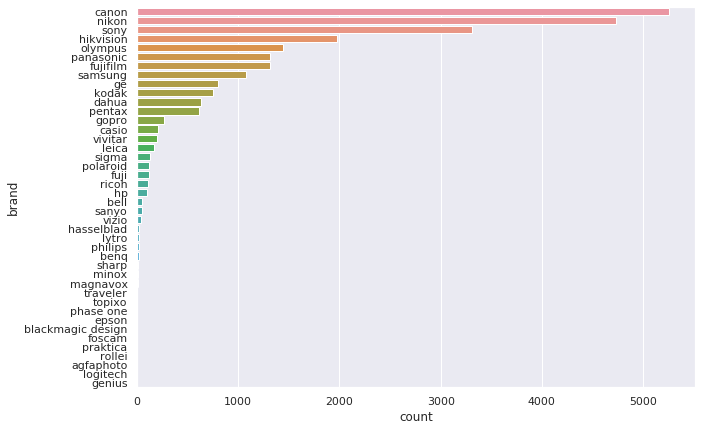

In [93]:
plt.figure()
sns.countplot(y='brand', data=specs_df, order=specs_df.brand.value_counts().index)
plt.show()

Unknown brands

In [98]:
null_brand = specs_df[specs_df.brand.isnull()]
null_brand.sample(15)

,spec_id,site,page_title,brand
19714,www.flipkart.com//2324,www.flipkart.com,Buy Lowepro Transit Backpack 350 AW Camera Bag...,None
21679,www.alibaba.com//22805,www.alibaba.com,1.0 Mp Cmos 720p Dome Ahd Analog Cctv Camera S...,None
2016,www.ebay.com//47538,www.ebay.com,Jumbl | eBay,None
27658,www.alibaba.com//29041,www.alibaba.com,"Joylemarry 720p(1280*720p)pixels @30fps,Avi Di...",None
18663,buy.net//6474,buy.net,"Sakar IS326BLK Black Digital Camera (16.1 MP, ...",None
20346,www.alibaba.com//22708,www.alibaba.com,Universal Eva Custom Digital Camera Bag Case F...,None
22046,www.alibaba.com//37579,www.alibaba.com,Croco Fashion Camera Case - Buy Digital Camera...,None
20572,www.alibaba.com//7218,www.alibaba.com,Onvif Network 1.3megapixel Camera Ip Security ...,None
22742,www.alibaba.com//37017,www.alibaba.com,Fix Dome Plastic Case Ip Surveillance Camera W...,None
22594,www.alibaba.com//25039,www.alibaba.com,2014 New Technology 2 Megapixel 1080p Hd Cvi C...,None


In [99]:
null_brand.shape

(4917, 4)

Thats a lot of nulls!

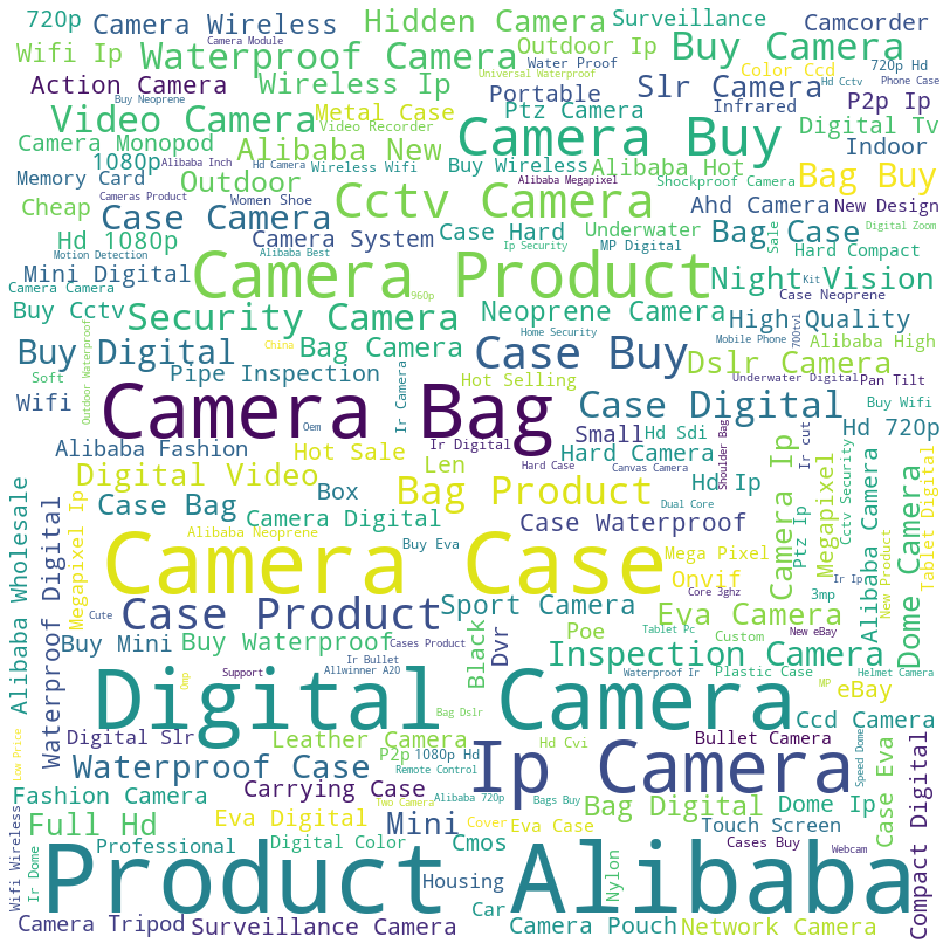

In [100]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(' '.join(null_brand.page_title.values))
  
plt.figure(figsize = (13, 13), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Effect of different preprocessings

In [48]:
import string
printable = set(string.printable)

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/boris/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [83]:
from nltk.corpus import stopwords 

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
stop = set(stopwords.words('english')) 

In [81]:
snow = nltk.stem.SnowballStemmer('english')

In [107]:
page_title = specs_df.page_title.sample(1).values[0]

print('1. Source page title\n', page_title)
only_printable = ' '.join([w for w in page_title.split(' ') if not w in printable])
print('2. Only printable\n', only_printable)
stemmed = ' '.join([snow.stem(word) for word in page_title.split(' ')])
print ('3. Stemmed\n', stemmed)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),
    min_df=0, max_df=999999999999)
vector = count_vectorizer.fit_transform([page_title,
                                        only_printable,
                                         stemmed
                                        ])

print('\nVectorized')
pd.DataFrame(vector.todense(), columns=count_vectorizer.get_feature_names())

1. Source page title
 Nikon D5100 Digital SLR Camera | eBay
2. Only printable
 Nikon D5100 Digital SLR Camera eBay
3. Stemmed
 nikon d5100 digit slr camera | ebay

Vectorized


,camera,camera ebay,d5100,d5100 digit,d5100 digital,digit,digit slr,digital,digital slr,ebay,nikon,nikon d5100,slr,slr camera
0,1,1,1,0,1,0,0,1,1,1,1,1,1,1
1,1,1,1,0,1,0,0,1,1,1,1,1,1,1
2,1,1,1,1,0,1,1,0,0,1,1,1,1,1


## Stopwords check

In [152]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=2)

In [180]:
count_vectorizer.fit(specs_df.page_title)
print(len(count_vectorizer.stop_words_))
list(count_vectorizer.stop_words_)[:30]

6359


['dp42849',
 's4252',
 '017852365843',
 '0074101401486',
 'fp2',
 '1749',
 '16409856',
 'fd51',
 '2600mm',
 '027242862432',
 'tvled1611',
 '241165',
 '0846951003901',
 '352',
 'atn201t',
 'shippings',
 'dscw510',
 '91029',
 '0037988985197',
 '840d',
 '885170047563',
 'f56',
 '18208261079',
 '041771483869',
 'hf3500',
 '25460',
 'hvcam',
 '5249',
 'candid',
 'gc200zkaxac']

In [183]:
specs_df.page_title[specs_df.page_title.apply(lambda x: x.lower()).str.contains('dp42849')].values[0]

'Sanyo DP42849 42" 1080i HD LCD Television 086483073489 | eBay'

In [167]:
count_vectorizer.get_feature_names()[:30]

['00',
 '000',
 '00018208099887',
 '0001820825507',
 '0009322239006',
 '001',
 '0013803001983',
 '0013803005912',
 '0013803011654',
 '0013803024487',
 '0013803037685',
 '0013803043846',
 '0013803062779',
 '0013803071122',
 '0013803123067',
 '0013803132618',
 '0013803133677',
 '0013803133752',
 '0013803134667',
 '0013803134674',
 '0013803146691',
 '0018208099894',
 '0018208131808',
 '0018208250400',
 '0018208252039',
 '0018208252084',
 '0018208254545',
 '0018208255214',
 '0018208255245',
 '0018208255320']

## Should we remove all ids, or should we keep them?